In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import time
# Download required NLTK data
nltk.download('punkt_tab', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")


In [ ]:
import pandas as pd


#df = pd.read_csv('//workspaces/ComplaintClassifcationUsingNLPAndNueralNetwork/Balanced_Complaints_Dataset_1000.csv')
df = pd.read_csv('/workspaces/ComplaintClassifcationUsingNLPAndNueralNetwork/BigBasketCompliants.csv')

SECTION 1.1: EXPLORATORY DATA ANALYSIS (EDA)

 DATASET OVERVIEW
------------------------------
Dataset Shape: (50000, 2)
Total Complaints: 50000
Features: ['Complaint Text', 'Category']
Missing Values: 0

First 3 samples:

Sample 1:
  Text: very Items embody missing from my delivery.
  Category: Missing Items

Sample 2:
  Text: The milk packet open burst during delivery.
  Category: Spillage in Delivery

Sample 3:
  Text: reply daytime for a I from customer
  Category: Customer Support Delay

 CLASS DISTRIBUTION ANALYSIS
----------------------------------------
Number of unique categories: 20
Average samples per class: 2500.0
Most frequent: 'Order Cancellation Without Notice' (2670 samples)
Least frequent: 'Delivery Executive Issue' (1061 samples)
Imbalance ratio (max/min): 2.52

Complete class distribution:
 1. Order Cancellation Without Notice : 2670 (  5.3%)
 2. Wrong Address Delivery         : 2664 (  5.3%)
 3. Missing Items                  : 2629 (  5.3%)
 4. Tracking Issue      

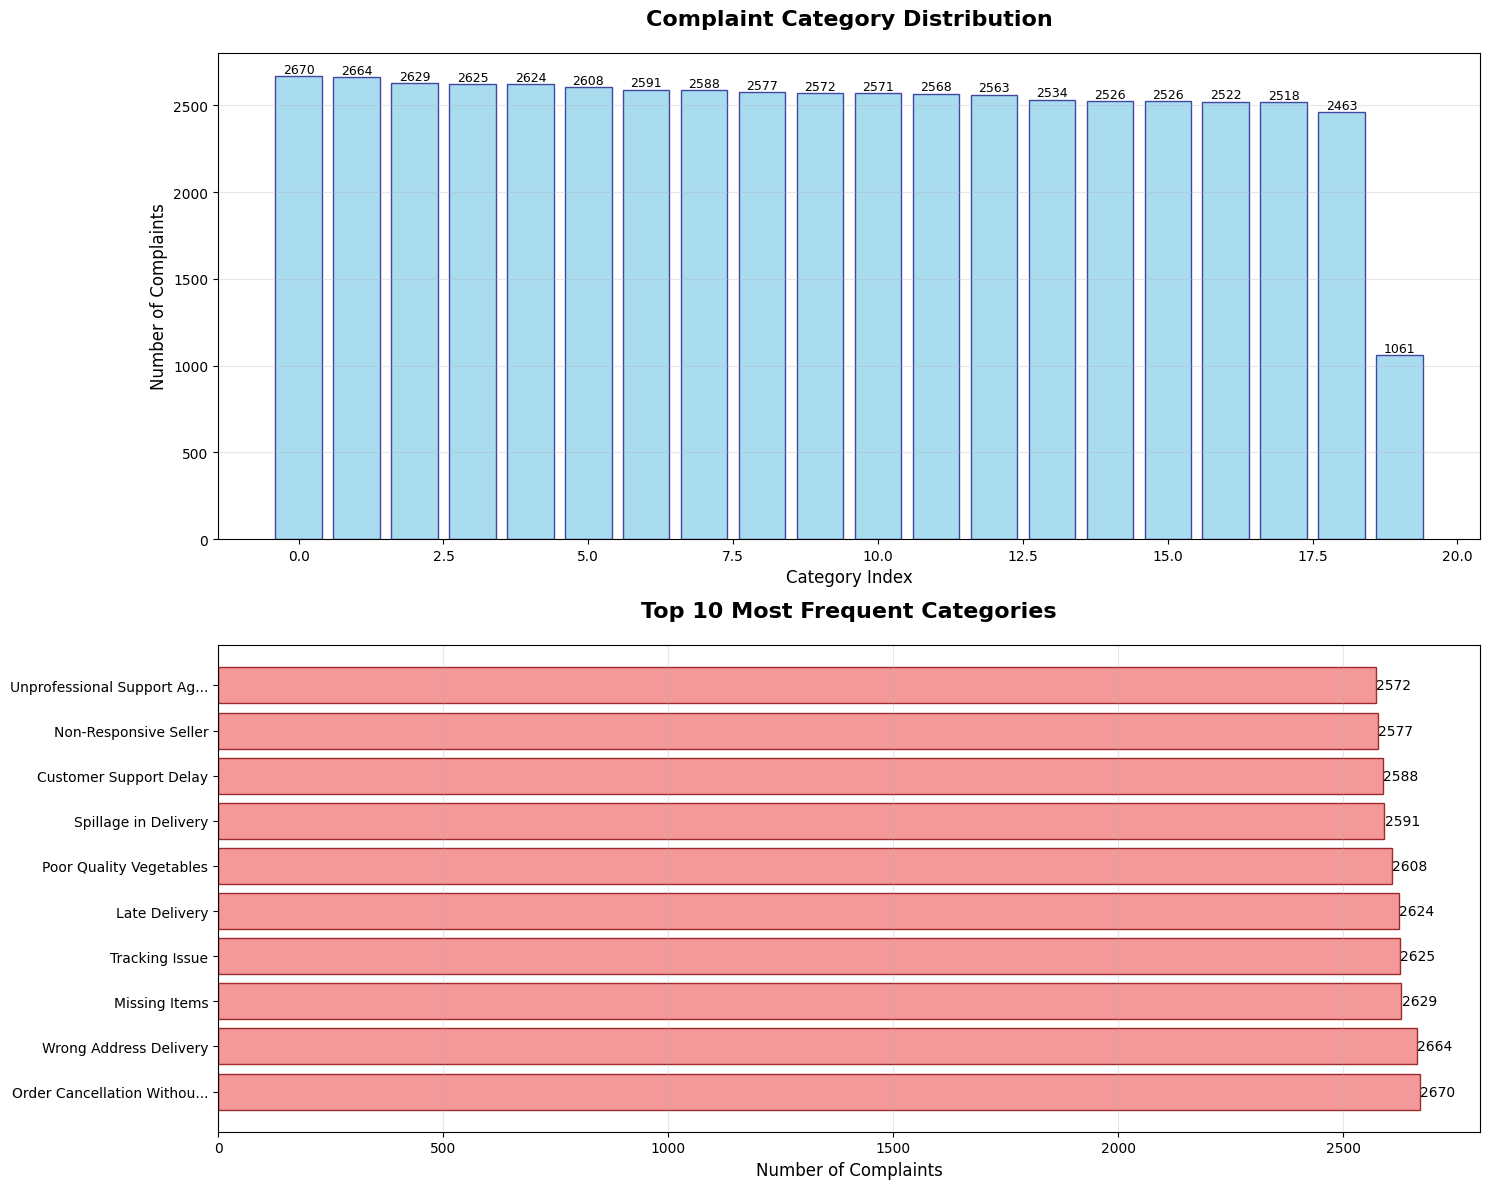


 COMPLAINT LENGTH ANALYSIS
-----------------------------------
Word Count Statistics:
  Mean: 6.8 words
  Median: 7.0 words
  Min: 3 words
  Max: 13 words
  Std Dev: 1.6 words

Character Count Statistics:
  Mean: 41.7 characters
  Median: 41.0 characters

Length Percentiles (for sequence padding):
  50th percentile:  7.0 words
  75th percentile:  8.0 words
  85th percentile:  8.0 words
  90th percentile:  9.0 words
  95th percentile: 10.0 words
  99th percentile: 11.0 words


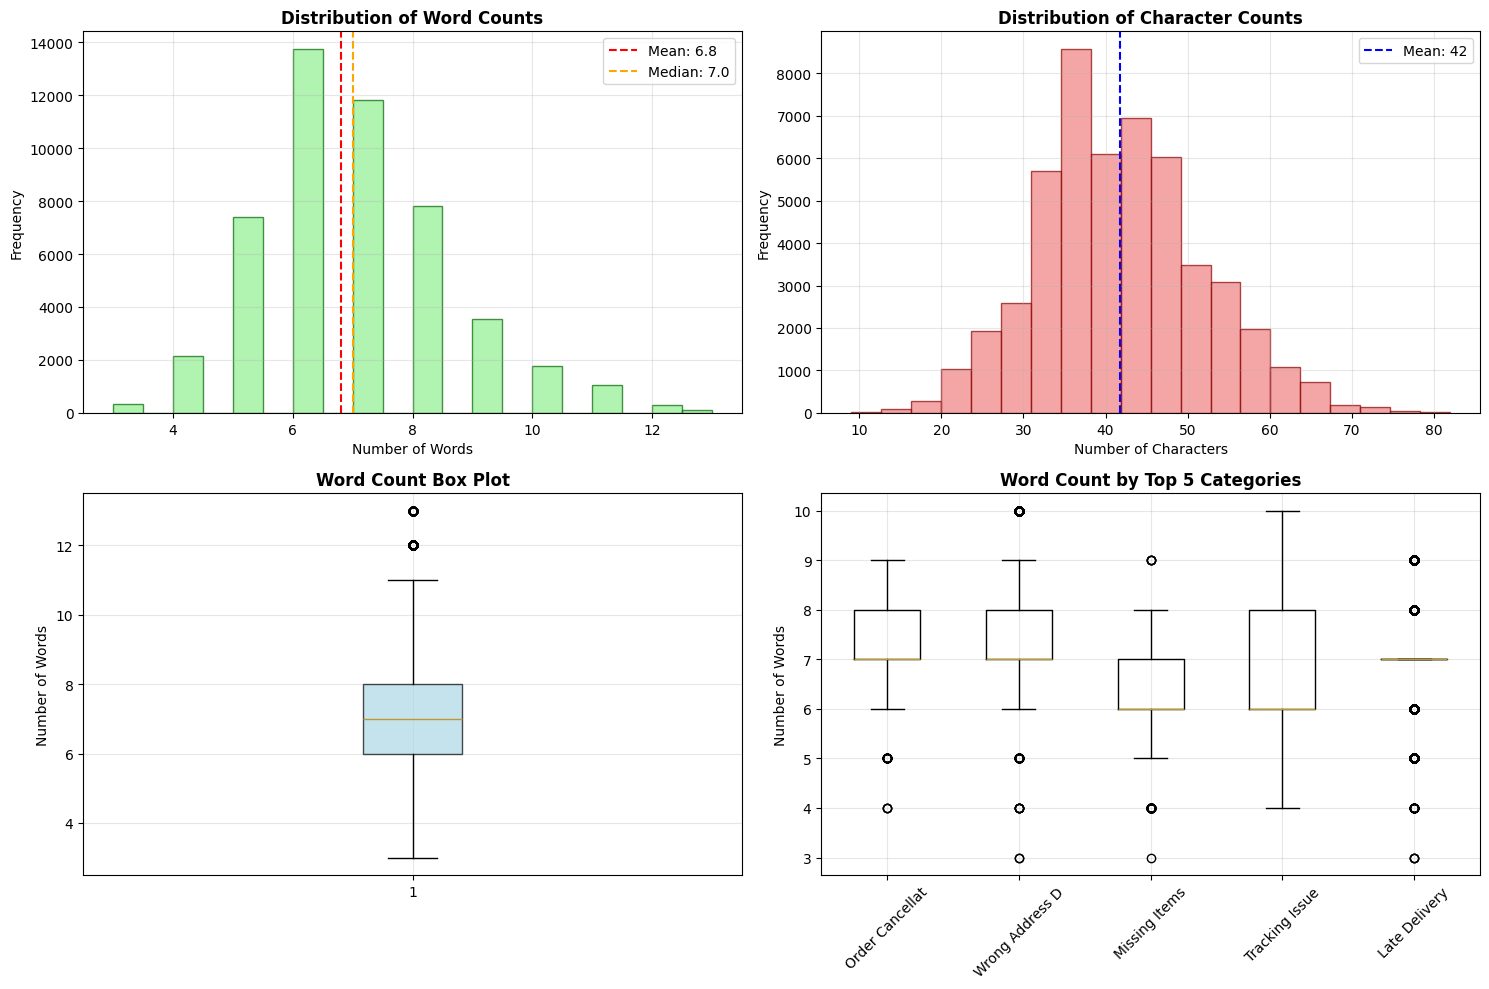


 Section 1.1 (EDA) completed successfully!
Key findings:
   • 20 complaint categories with mild imbalance (ratio: 2.52)
   • Average complaint length: 6.8 words
   • Recommended sequence padding: 20-25 words (covers 95%+ complaints)


In [29]:
#2
print("="*60)
print("SECTION 1.1: EXPLORATORY DATA ANALYSIS (EDA)")
print("="*60)

# Basic dataset information
print("\n DATASET OVERVIEW")
print("-" * 30)
print(f"Dataset Shape: {df.shape}")
print(f"Total Complaints: {len(df)}")
print(f"Features: {list(df.columns)}")
print(f"Missing Values: {df.isnull().sum().sum()}")

print(f"\nFirst 3 samples:")
for i in range(3):
    print(f"\nSample {i+1}:")
    print(f"  Text: {df['Complaint Text'].iloc[i]}")
    print(f"  Category: {df['Category'].iloc[i]}")

# CLASS DISTRIBUTION ANALYSIS
print("\n CLASS DISTRIBUTION ANALYSIS")
print("-" * 40)

class_counts = df['Category'].value_counts()
n_classes = len(class_counts)
total_samples = len(df)
avg_per_class = total_samples / n_classes
imbalance_ratio = class_counts.max() / class_counts.min()

print(f"Number of unique categories: {n_classes}")
print(f"Average samples per class: {avg_per_class:.1f}")
print(f"Most frequent: '{class_counts.index[0]}' ({class_counts.iloc[0]} samples)")
print(f"Least frequent: '{class_counts.index[-1]}' ({class_counts.iloc[-1]} samples)")
print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")

print(f"\nComplete class distribution:")
for i, (category, count) in enumerate(class_counts.items()):
    percentage = (count/total_samples)*100
    print(f"{i+1:2d}. {category:<30} : {count:3d} ({percentage:5.1f}%)")

# Visualize class distribution
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Bar chart
axes[0].bar(range(len(class_counts)), class_counts.values, 
           color='skyblue', edgecolor='navy', alpha=0.7)
axes[0].set_title('Complaint Category Distribution', fontsize=16, fontweight='bold', pad=20)
axes[0].set_xlabel('Category Index', fontsize=12)
axes[0].set_ylabel('Number of Complaints', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 1, str(v), ha='center', va='bottom', fontsize=9)

# Horizontal bar chart for top 10
top_10 = class_counts.head(10)
bars = axes[1].barh(range(len(top_10)), top_10.values, 
                   color='lightcoral', edgecolor='darkred', alpha=0.8)
axes[1].set_yticks(range(len(top_10)))
axes[1].set_yticklabels([label[:25] + '...' if len(label) > 25 else label 
                        for label in top_10.index], fontsize=10)
axes[1].set_title('Top 10 Most Frequent Categories', fontsize=16, fontweight='bold', pad=20)
axes[1].set_xlabel('Number of Complaints', fontsize=12)
axes[1].grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(top_10.values):
    axes[1].text(v + 0.5, i, str(v), ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# COMPLAINT LENGTH ANALYSIS
print("\n COMPLAINT LENGTH ANALYSIS")
print("-" * 35)

# Calculate lengths
df['word_count'] = df['Complaint Text'].apply(lambda x: len(x.split()))
df['char_count'] = df['Complaint Text'].apply(len)

# Statistics
word_stats = df['word_count'].describe()
char_stats = df['char_count'].describe()

print(f"Word Count Statistics:")
print(f"  Mean: {word_stats['mean']:.1f} words")
print(f"  Median: {word_stats['50%']:.1f} words")
print(f"  Min: {word_stats['min']:.0f} words")
print(f"  Max: {word_stats['max']:.0f} words")
print(f"  Std Dev: {word_stats['std']:.1f} words")

print(f"\nCharacter Count Statistics:")
print(f"  Mean: {char_stats['mean']:.1f} characters")
print(f"  Median: {char_stats['50%']:.1f} characters")

# Percentiles for padding decision
percentiles = [50, 75, 85, 90, 95, 99]
print(f"\nLength Percentiles (for sequence padding):")
for p in percentiles:
    word_percentile = np.percentile(df['word_count'], p)
    print(f"  {p:2d}th percentile: {word_percentile:4.1f} words")

# Visualize length distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Word count histogram
axes[0,0].hist(df['word_count'], bins=20, color='lightgreen', 
               edgecolor='darkgreen', alpha=0.7)
axes[0,0].axvline(df['word_count'].mean(), color='red', linestyle='--', 
                 label=f'Mean: {df["word_count"].mean():.1f}')
axes[0,0].axvline(df['word_count'].median(), color='orange', linestyle='--', 
                 label=f'Median: {df["word_count"].median():.1f}')
axes[0,0].set_title('Distribution of Word Counts', fontweight='bold')
axes[0,0].set_xlabel('Number of Words')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# Character count histogram
axes[0,1].hist(df['char_count'], bins=20, color='lightcoral', 
               edgecolor='darkred', alpha=0.7)
axes[0,1].axvline(df['char_count'].mean(), color='blue', linestyle='--', 
                 label=f'Mean: {df["char_count"].mean():.0f}')
axes[0,1].set_title('Distribution of Character Counts', fontweight='bold')
axes[0,1].set_xlabel('Number of Characters')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

# Box plots
axes[1,0].boxplot(df['word_count'], vert=True, patch_artist=True,
                 boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[1,0].set_title('Word Count Box Plot', fontweight='bold')
axes[1,0].set_ylabel('Number of Words')
axes[1,0].grid(alpha=0.3)

# Length by category (top 5 categories)
top_5_cats = class_counts.head(5).index
length_by_cat = [df[df['Category'] == cat]['word_count'].tolist() for cat in top_5_cats]
axes[1,1].boxplot(length_by_cat, labels=[cat[:15] for cat in top_5_cats])
axes[1,1].set_title('Word Count by Top 5 Categories', fontweight='bold')
axes[1,1].set_ylabel('Number of Words')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n Section 1.1 (EDA) completed successfully!")
print(f"Key findings:")
print(f"   • {n_classes} complaint categories with mild imbalance (ratio: {imbalance_ratio:.2f})")
print(f"   • Average complaint length: {word_stats['mean']:.1f} words")
print(f"   • Recommended sequence padding: 20-25 words (covers 95%+ complaints)")

In [30]:
print("="*60)
print("SECTION 1.2: TEXT PREPROCESSING")
print("="*60)

# Initialize preprocessing tools
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def improved_preprocessing_pipeline(text):
    """Improved preprocessing to preserve vocabulary while cleaning text"""
    # Step 1: Basic cleaning
    text = text.lower()
    text = re.sub(r'^bigbasket\s*-?\s*', '', text)  # Remove bigbasket prefix
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)    # Keep alphanumeric
    text = re.sub(r'\s+', ' ', text).strip()        # Clean whitespace
    
    # Step 2: Tokenization
    word_tokens = word_tokenize(text)
    
    # Step 3: Remove only common stopwords, keep important words
    stop_words = set(stopwords.words('english'))
    # Keep negations and important words
    keep_words = {'not', 'no', 'nor', 'never', 'bad', 'good', 'great', 'poor', 'excellent', 'terrible'}
    filtered_stopwords = stop_words - keep_words
    
    # Filter tokens - keep words longer than 2 characters
    filtered_text = [word for word in word_tokens 
                    if word.lower() not in filtered_stopwords and len(word) > 2]
    
    # Step 4: Lemmatization
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_text]
    
    return ' '.join(lemmatized_words)

# Apply preprocessing
print("Processing dataset...")
df['processed_text'] = df['Complaint Text'].apply(improved_preprocessing_pipeline)

# Label encoding
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['Category'])

# Show examples
print("\nPreprocessing Examples:")
print("-" * 50)
for i in range(3):
    print(f"Sample {i+1}:")
    print(f"  Original:  {df['Complaint Text'].iloc[i][:80]}...")
    print(f"  Processed: {df['processed_text'].iloc[i]}")
    print(f"  Category:  {df['Category'].iloc[i]} (encoded: {df['category_encoded'].iloc[i]})")
    print()

# Calculate vocabulary statistics
vocab_size = len(set(' '.join(df['processed_text']).split()))
avg_length = df['processed_text'].apply(lambda x: len(x.split())).mean()

print(f"Processing Results:")
print(f"  Dataset size: {len(df):,} complaints")
print(f"  Vocabulary size: {vocab_size:,} unique words")
print(f"  Average text length: {avg_length:.1f} words")
print(f"  Number of categories: {len(label_encoder.classes_)}")


SECTION 1.2: TEXT PREPROCESSING
Processing dataset...

Preprocessing Examples:
--------------------------------------------------
Sample 1:
  Original:  very Items embody missing from my delivery....
  Processed: item embody missing delivery
  Category:  Missing Items (encoded: 8)

Sample 2:
  Original:  The milk packet open burst during delivery....
  Processed: milk packet open burst delivery
  Category:  Spillage in Delivery (encoded: 15)

Sample 3:
  Original:  reply daytime for a I from customer...
  Processed: reply daytime customer
  Category:  Customer Support Delay (encoded: 1)

Processing Results:
  Dataset size: 50,000 complaints
  Vocabulary size: 6,335 unique words
  Average text length: 4.3 words
  Number of categories: 20


In [31]:
#4
print("\nCATEGORY ENCODING MAPPING:")
print("-" * 40)
print(f"{'Category Name':<30} {'Encoded Label':<15}")
print("-" * 45)
for i, category in enumerate(label_encoder.classes_):
    print(f"{category:<30} {i:<15}")

print(f"\nEncoding Details:")
print(f"• Total categories: {len(label_encoder.classes_)}")
print(f"• Encoding range: 0 to {len(label_encoder.classes_)-1}")
print(f"• Encoding method: Alphabetical order")


CATEGORY ENCODING MAPPING:
----------------------------------------
Category Name                  Encoded Label  
---------------------------------------------
App/Technical Issue            0              
Customer Support Delay         1              
Damaged Product                2              
Delivery Executive Issue       3              
Duplicate Charge               4              
Inconsistent Order Status      5              
Incorrect Order                6              
Late Delivery                  7              
Missing Items                  8              
Non-Responsive Seller          9              
Order Cancellation Without Notice 10             
Payment Issue                  11             
Poor Quality Vegetables        12             
Promotional Code Issue         13             
Refund Issue                   14             
Spillage in Delivery           15             
Tracking Issue                 16             
Unhygienic Packaging           17   

## section 2


In [32]:
# Cell 5: Load FastText Embeddings
print("="*50)
print("LOADING FASTTEXT EMBEDDINGS")
print("="*50)

def load_fasttext_embeddings(file_path, max_words=20000):
    """Load FastText embeddings manually"""
    embeddings = {}
    
    with open(file_path, 'r', encoding='utf-8') as f:
        # Skip header
        next(f)
        
        for i, line in enumerate(f):
            if i >= max_words:
                break
                
            values = line.strip().split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    
    return embeddings

# Load embeddings
try:
    fasttext_path = '/workspaces/ComplaintClassifcationUsingNLPAndNueralNetwork/nlp project/wiki-news-300d-1M.vec'
    embeddings_dict = load_fasttext_embeddings(fasttext_path)
    EMBEDDING_DIM = len(list(embeddings_dict.values())[0])
    
    print(f"FastText loaded successfully!")
    print(f"   Words: {len(embeddings_dict):,}")
    print(f"   Dimensions: {EMBEDDING_DIM}")
    
except Exception as e:
    print(f"Failed to load FastText: {e}")
    print("Using random embeddings instead")
    embeddings_dict = None
    EMBEDDING_DIM = 100

LOADING FASTTEXT EMBEDDINGS
FastText loaded successfully!
   Words: 20,000
   Dimensions: 300


In [33]:
# Vocabulary & Embedding Matrix Creation
print("="*50)
print("VOCABULARY & EMBEDDINGS")
print("="*50)

# Build vocabulary from processed text
MAX_VOCAB = 20000
word_counts = Counter()

# Use the correct column name from preprocessing
for text in df['processed_text']:
    word_counts.update(text.split())

# Create vocabulary mappings
vocab_words = ['<PAD>', '<UNK>'] + [word for word, _ in word_counts.most_common(MAX_VOCAB-2)]
word_to_idx = {word: idx for idx, word in enumerate(vocab_words)}
vocab_size = len(vocab_words)

print(f"Vocabulary size: {vocab_size}")
print(f"Most common words: {list(word_counts.most_common(5))}")

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
words_found = 0

if embeddings_dict:
    for word, idx in word_to_idx.items():
        if word in ['<PAD>', '<UNK>']:
            if word == '<UNK>':
                embedding_matrix[idx] = np.random.normal(0, 0.1, EMBEDDING_DIM)
            continue
            
        if word in embeddings_dict:
            embedding_matrix[idx] = embeddings_dict[word]
            words_found += 1
        else:
            embedding_matrix[idx] = np.random.normal(0, 0.1, EMBEDDING_DIM)
    
    coverage = (words_found / (vocab_size - 2)) * 100
    print(f"FastText coverage: {coverage:.1f}%")
else:
    embedding_matrix = np.random.normal(0, 0.1, (vocab_size, EMBEDDING_DIM))

print(f"Embedding matrix shape: {embedding_matrix.shape}")
print("Vocabulary and embeddings ready!")

VOCABULARY & EMBEDDINGS
Vocabulary size: 6337
Most common words: [('order', 9435), ('morning', 8030), ('item', 7144), ('not', 5615), ('received', 4376)]
FastText coverage: 11.2%
Embedding matrix shape: (6337, 300)
Vocabulary and embeddings ready!


In [34]:
# Data Preparation for PyTorch Training
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import numpy as np

def text_to_sequences_pytorch(texts, word_to_idx, max_len=25):
    """Convert texts to sequences for PyTorch"""
    sequences = []
    unk_idx = word_to_idx['<UNK>']
    
    for text in texts:
        seq = [word_to_idx.get(word, unk_idx) for word in text.split()]
        
        # Pad or truncate to max_len
        if len(seq) < max_len:
            seq += [0] * (max_len - len(seq))  # Pad with 0 (<PAD>)
        else:
            seq = seq[:max_len]  # Truncate
            
        sequences.append(seq)
    
    return torch.tensor(sequences, dtype=torch.long)

# Convert to PyTorch tensors using correct column name
MAX_LEN = 25
X = text_to_sequences_pytorch(df['processed_text'], word_to_idx, MAX_LEN)
y = torch.tensor(df['category_encoded'].values, dtype=torch.long)

# Split data for training and testing
X_np, y_np = X.numpy(), y.numpy()
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_np, y_np, test_size=0.2, random_state=42, stratify=y_np
)

# Convert back to PyTorch tensors
X_train = torch.tensor(X_train_np, dtype=torch.long)
X_test = torch.tensor(X_test_np, dtype=torch.long)
y_train = torch.tensor(y_train_np, dtype=torch.long)
y_test = torch.tensor(y_test_np, dtype=torch.long)

print(f"Data prepared for training:")
print(f"  Train set: {X_train.shape}, {y_train.shape}")
print(f"  Test set: {X_test.shape}, {y_test.shape}")
print(f"  Number of classes: {len(torch.unique(y))}")
print(f"  Sequence length: {MAX_LEN}")

# Convert embedding matrix to PyTorch tensor
embedding_matrix_torch = torch.tensor(embedding_matrix, dtype=torch.float32)
print(f"  Embedding matrix: {embedding_matrix_torch.shape}")
print("Data preparation completed!")

Data prepared for training:
  Train set: torch.Size([40000, 25]), torch.Size([40000])
  Test set: torch.Size([10000, 25]), torch.Size([10000])
  Number of classes: 20
  Sequence length: 25
  Embedding matrix: torch.Size([6337, 300])
Data preparation completed!


# Section 3

## Section 3.1

In [35]:
# SECTION 3: NEURAL NETWORK MODEL DEVELOPMENT
print("="*60)
print("SECTION 3: NEURAL NETWORK MODEL DEVELOPMENT")
print("="*60)



# Set device for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using computational device: {device}")

# Model parameters
num_classes = len(label_encoder.classes_)
vocab_size = len(word_to_idx)
EMBEDDING_DIM = embedding_matrix.shape[1]  # FastText dimension
MAX_LEN = 25
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 20

print(f"Model Configuration:")
print(f"  Vocabulary size: {vocab_size:,}")
print(f"  Embedding dimension: {EMBEDDING_DIM}")
print(f"  Number of classes: {num_classes}")
print(f"  Sequence length: {MAX_LEN}")
print(f"  Training epochs: {NUM_EPOCHS}")

# Neural Network Architecture
class ComplaintClassifier(nn.Module):
    """Feedforward Neural Network for Text Classification"""
    def __init__(self, vocab_size, embedding_dim, num_classes, embedding_matrix):
        super(ComplaintClassifier, self).__init__()
        
        # Pre-trained embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(embedding_matrix)
        self.embedding.weight.requires_grad = False  # Freeze embeddings
        
        # Neural network layers
        self.fc1 = nn.Linear(embedding_dim, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        # Get embeddings and average pool
        embedded = self.embedding(x)
        pooled = torch.mean(embedded, dim=1)
        
        # Forward pass through network
        x = F.relu(self.fc1(pooled))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

print("Neural network architecture defined successfully.")

SECTION 3: NEURAL NETWORK MODEL DEVELOPMENT
Using computational device: cpu
Model Configuration:
  Vocabulary size: 6,337
  Embedding dimension: 300
  Number of classes: 20
  Sequence length: 25
  Training epochs: 20
Neural network architecture defined successfully.


In [36]:
# Model Training and Evaluation
print("="*50)
print("MODEL TRAINING AND EVALUATION")
print("="*50)

# Prepare data for training
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)
embedding_matrix_torch = embedding_matrix_torch.to(device)

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model
model = ComplaintClassifier(vocab_size, EMBEDDING_DIM, num_classes, embedding_matrix_torch).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

print(f"Model initialized with {sum(p.numel() for p in model.parameters()):,} parameters")
def train_model_quiet(model, train_loader, optimizer, criterion, num_epochs, model_name="Model"):
    """Training function without duplicate output"""
    model.train()
    training_losses = []
    training_accuracies = []
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        total_loss = 0
        correct_predictions = 0
        total_samples = 0
        
        for batch_data, batch_labels in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_samples += batch_labels.size(0)
            correct_predictions += (predicted == batch_labels).sum().item()
        
        # Calculate metrics
        avg_loss = total_loss / len(train_loader)
        accuracy = 100 * correct_predictions / total_samples
        
        training_losses.append(avg_loss)
        training_accuracies.append(accuracy)
        
        if (epoch + 1) % 5 == 0:
            print(f"{model_name} - Epoch [{epoch+1:2d}/{num_epochs}] - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    training_time = time.time() - start_time
    print(f"{model_name} training completed in {training_time:.1f} seconds")
    
    return training_losses, training_accuracies


# Train the model
print("Starting Feedforward model training...")
train_losses, train_accuracies = train_model_quiet(model, train_loader, optimizer, criterion, NUM_EPOCHS, "Feedforward")

MODEL TRAINING AND EVALUATION
Model initialized with 1,949,184 parameters
Starting Feedforward model training...
Feedforward - Epoch [ 5/20] - Loss: 0.1191, Accuracy: 96.61%
Feedforward - Epoch [10/20] - Loss: 0.0593, Accuracy: 98.27%
Feedforward - Epoch [15/20] - Loss: 0.0363, Accuracy: 98.93%
Feedforward - Epoch [20/20] - Loss: 0.0263, Accuracy: 99.23%
Feedforward training completed in 32.5 seconds


In [37]:
# Model Evaluation
print("="*50)
print("MODEL EVALUATION")
print("="*50)

def evaluate_model(model, test_loader):
    """Evaluate model performance"""
    model.eval()
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            outputs = model(batch_data)
            _, predicted = torch.max(outputs, 1)
            
            total_samples += batch_labels.size(0)
            correct_predictions += (predicted == batch_labels).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(batch_labels.cpu().numpy())
    
    accuracy = 100 * correct_predictions / total_samples
    return accuracy, all_predictions, all_targets

# Evaluate the trained model
test_accuracy, predictions, targets = evaluate_model(model, test_loader)

print(f"Model Performance Results:")
print(f"  Test Accuracy: {test_accuracy:.2f}%")
print(f"  Training Accuracy (final): {train_accuracies[-1]:.2f}%")

# Detailed classification report
print(f"\nDetailed Classification Report:")
print("-" * 50)
report = classification_report(targets, predictions, 
                             target_names=label_encoder.classes_, 
                             digits=3)
print(report)

# Show some prediction examples
print(f"\nPrediction Examples:")
print("-" * 30)
for i in range(5):
    original_text = df['Complaint Text'].iloc[i][:80] + "..."
    true_category = label_encoder.classes_[targets[i]]
    pred_category = label_encoder.classes_[predictions[i]]
    
    print(f"Text: {original_text}")
    print(f"True: {true_category}")
    print(f"Predicted: {pred_category}")
    print(f"Match: {'✓' if targets[i] == predictions[i] else '✗'}")
    print()

print("Model evaluation completed.")

MODEL EVALUATION
Model Performance Results:
  Test Accuracy: 98.98%
  Training Accuracy (final): 99.23%

Detailed Classification Report:
--------------------------------------------------
                                   precision    recall  f1-score   support

              App/Technical Issue      0.988     0.978     0.983       505
           Customer Support Delay      0.998     0.990     0.994       518
                  Damaged Product      0.978     0.984     0.981       503
         Delivery Executive Issue      0.972     0.972     0.972       212
                 Duplicate Charge      0.994     0.990     0.992       514
        Inconsistent Order Status      0.979     0.996     0.987       514
                  Incorrect Order      0.971     0.982     0.976       504
                    Late Delivery      1.000     0.996     0.998       525
                    Missing Items      0.979     0.987     0.983       526
            Non-Responsive Seller      1.000     0.990     0.

In [38]:
# Practical Prediction System
print("="*50)
print("PRACTICAL PREDICTION SYSTEM")
print("="*50)

def predict_complaint_category(text):
    """Predict complaint category for new text"""
    # Preprocess the input text
    processed_text = improved_preprocessing_pipeline(text)
    
    # Convert to model input format
    sequence = text_to_sequences_pytorch([processed_text], word_to_idx, MAX_LEN)
    sequence = sequence.to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(sequence)
        probabilities = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities).item()
        confidence = probabilities[0][predicted_class].item() * 100
    
    # Get category name
    category = label_encoder.classes_[predicted_class]
    
    return category, confidence

# Test the prediction system
print("Testing prediction system with sample complaints:")
print("-" * 50)

test_complaints = [
    "The vegetables I ordered were rotten and smelled bad",
    "My order was cancelled without any notification",
    "The mobile app keeps crashing when I try to place order",
    "Payment was deducted but order was not confirmed",
    "Delivery was very late and food was cold"
]

for i, complaint in enumerate(test_complaints, 1):
    category, confidence = predict_complaint_category(complaint)
    print(f"Test {i}:")
    print(f"  Complaint: {complaint}")
    print(f"  Predicted Category: {category}")
    print(f"  Confidence: {confidence:.1f}%")
    print()

print("Prediction system ready for use!")
print("Usage: predict_complaint_category('your complaint text here')")

PRACTICAL PREDICTION SYSTEM
Testing prediction system with sample complaints:
--------------------------------------------------
Test 1:
  Complaint: The vegetables I ordered were rotten and smelled bad
  Predicted Category: Poor Quality Vegetables
  Confidence: 100.0%

Test 2:
  Complaint: My order was cancelled without any notification
  Predicted Category: Order Cancellation Without Notice
  Confidence: 100.0%

Test 3:
  Complaint: The mobile app keeps crashing when I try to place order
  Predicted Category: Tracking Issue
  Confidence: 100.0%

Test 4:
  Complaint: Payment was deducted but order was not confirmed
  Predicted Category: Payment Issue
  Confidence: 100.0%

Test 5:
  Complaint: Delivery was very late and food was cold
  Predicted Category: Spillage in Delivery
  Confidence: 99.9%

Prediction system ready for use!
Usage: predict_complaint_category('your complaint text here')


TRAINING RESULTS VISUALIZATION


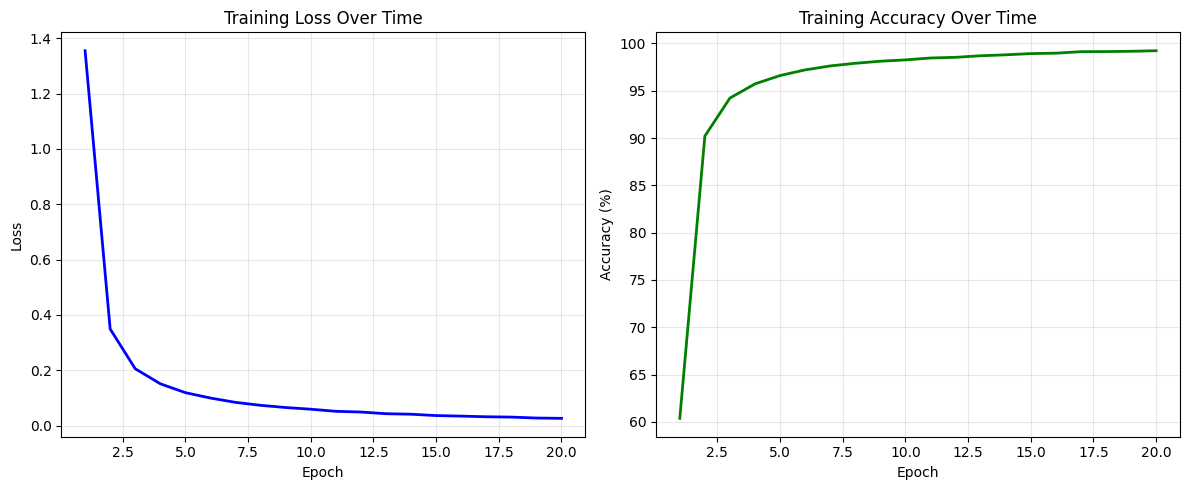

Training Summary:
  Initial Loss: 1.3547
  Final Loss: 0.0263
  Initial Accuracy: 60.38%
  Final Accuracy: 99.23%
  Test Accuracy: 98.98%
  Improvement: 38.86%

Model training and evaluation completed successfully!


In [39]:
# Training Results Visualization
import matplotlib.pyplot as plt

print("="*50)
print("TRAINING RESULTS VISUALIZATION")
print("="*50)

# Create training plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training loss
ax1.plot(range(1, len(train_losses) + 1), train_losses, 'b-', linewidth=2)
ax1.set_title('Training Loss Over Time')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True, alpha=0.3)

# Plot training accuracy
ax2.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'g-', linewidth=2)
ax2.set_title('Training Accuracy Over Time')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"Training Summary:")
print(f"  Initial Loss: {train_losses[0]:.4f}")
print(f"  Final Loss: {train_losses[-1]:.4f}")
print(f"  Initial Accuracy: {train_accuracies[0]:.2f}%")
print(f"  Final Accuracy: {train_accuracies[-1]:.2f}%")
print(f"  Test Accuracy: {test_accuracy:.2f}%")
print(f"  Improvement: {train_accuracies[-1] - train_accuracies[0]:.2f}%")

print("\nModel training and evaluation completed successfully!")

In [40]:
# Additional Testing (Optional)
# You can test more examples here if needed

print("="*50)
print("ADDITIONAL TESTING AREA")
print("="*50)

# Test with your own examples
print("You can test the model with custom complaints:")
print("Example: predict_complaint_category('your complaint here')")
print()
print("Model is ready for use!")

ADDITIONAL TESTING AREA
You can test the model with custom complaints:
Example: predict_complaint_category('your complaint here')

Model is ready for use!


In [41]:

print(f"\nFinal Model Performance:")
print(f"  Test Accuracy: {test_accuracy:.1f}%")
print(f"  Vocabulary Size: {vocab_size:,} words")
print(f"  Training completed successfully!")



Final Model Performance:
  Test Accuracy: 99.0%
  Vocabulary Size: 6,337 words
  Training completed successfully!


In [42]:
# Test the prediction system with sample complaints
print("="*50)
print("TESTING PREDICTION SYSTEM")
print("="*50)

# Test with predefined examples
test_examples = [
    "The fruits were bad",
    "My order never arrived", 
    "Website keeps crashing"
]

for complaint in test_examples:
    category, confidence = predict_complaint_category(complaint)
    print(f"Complaint: '{complaint}'")
    print(f"Predicted Category: {category}")
    print(f"Confidence: {confidence:.1f}%")
    print("-" * 30)

print("System ready for interactive testing!")

TESTING PREDICTION SYSTEM
Complaint: 'The fruits were bad'
Predicted Category: Poor Quality Vegetables
Confidence: 98.9%
------------------------------
Complaint: 'My order never arrived'
Predicted Category: Inconsistent Order Status
Confidence: 51.6%
------------------------------
Complaint: 'Website keeps crashing'
Predicted Category: Tracking Issue
Confidence: 93.6%
------------------------------
System ready for interactive testing!


In [43]:
'''# SIMPLE DEMO FUNCTIONS (OPTIONAL)
print("="*60)
print("OPTIONAL: SIMPLE DEMO FUNCTIONS")
print("="*60)


def quick_demo():
    
    examples = [
        "The vegetables were rotten and smelled terrible",
        "My payment was charged but order was cancelled",
        "App crashed during checkout process"
    ]
    
    print("Quick Demo Examples:")
    print("="*40)
    
    for i, complaint in enumerate(examples, 1):
        print(f"\nExample {i}:")
        predict_complaint(complaint)
        print("-" * 50)


print("\nThat's it! Just use predict_complaint() for everything.")'''

'# SIMPLE DEMO FUNCTIONS (OPTIONAL)\nprint("="*60)\nprint("OPTIONAL: SIMPLE DEMO FUNCTIONS")\nprint("="*60)\n\n\ndef quick_demo():\n\n    examples = [\n        "The vegetables were rotten and smelled terrible",\n        "My payment was charged but order was cancelled",\n        "App crashed during checkout process"\n    ]\n\n    print("Quick Demo Examples:")\n    print("="*40)\n\n    for i, complaint in enumerate(examples, 1):\n        print(f"\nExample {i}:")\n        predict_complaint(complaint)\n        print("-" * 50)\n\n\nprint("\nThat\'s it! Just use predict_complaint() for everything.")'

In [44]:
# LSTM MODEL DEVELOPMENT
print("="*60)
print("SECTION 4: LSTM MODEL DEVELOPMENT")
print("="*60)

class LSTMComplaintClassifier(nn.Module):
    """LSTM Neural Network for Text Classification"""
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, embedding_matrix, num_layers=2):
        super(LSTMComplaintClassifier, self).__init__()
        
        # Pre-trained embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(embedding_matrix)
        self.embedding.weight.requires_grad = False  # Freeze embeddings
        
        # LSTM layers
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, 
                           batch_first=True, dropout=0.3, bidirectional=True)
        
        # Classification layers
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(hidden_dim * 2, 128)  # *2 for bidirectional
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        # Get embeddings
        embedded = self.embedding(x)
        
        # LSTM forward pass
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        # Use the last hidden state from both directions
        hidden_forward = hidden[-2]  # Last layer, forward direction
        hidden_backward = hidden[-1]  # Last layer, backward direction
        final_hidden = torch.cat([hidden_forward, hidden_backward], dim=1)
        
        # Classification layers
        x = self.dropout(final_hidden)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Modified training function to avoid duplicate output

# LSTM Training
print("Training LSTM Model...")
print("-" * 30)

# LSTM Model parameters
HIDDEN_DIM = 128
NUM_LAYERS = 2

# Initialize LSTM model
lstm_model = LSTMComplaintClassifier(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, 
                                   num_classes, embedding_matrix_torch, NUM_LAYERS).to(device)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)

print(f"LSTM Model initialized with {sum(p.numel() for p in lstm_model.parameters()):,} parameters")

# Train LSTM model
print("Starting LSTM training...")
lstm_train_losses, lstm_train_accuracies = train_model_quiet(lstm_model, train_loader, 
                                                           lstm_optimizer, criterion, NUM_EPOCHS, "LSTM")

# Evaluate LSTM model
lstm_test_accuracy, lstm_predictions, lstm_targets = evaluate_model(lstm_model, test_loader)

print(f"\nLSTM Model Performance:")
print(f"  Test Accuracy: {lstm_test_accuracy:.2f}%")
print(f"  Training Accuracy (final): {lstm_train_accuracies[-1]:.2f}%")
print("LSTM model training completed!")

SECTION 4: LSTM MODEL DEVELOPMENT
Training LSTM Model...
------------------------------
LSTM Model initialized with 2,779,136 parameters
Starting LSTM training...
LSTM - Epoch [ 5/20] - Loss: 0.0344, Accuracy: 99.11%


LSTM - Epoch [10/20] - Loss: 0.0141, Accuracy: 99.61%
LSTM - Epoch [15/20] - Loss: 0.0125, Accuracy: 99.71%
LSTM - Epoch [20/20] - Loss: 0.0092, Accuracy: 99.81%
LSTM training completed in 1002.6 seconds

LSTM Model Performance:
  Test Accuracy: 99.49%
  Training Accuracy (final): 99.81%
LSTM model training completed!


In [45]:
# CNN MODEL DEVELOPMENT
print("="*60)
print("SECTION 5: CNN MODEL DEVELOPMENT")
print("="*60)

class CNNComplaintClassifier(nn.Module):
    """CNN Neural Network for Text Classification"""
    def __init__(self, vocab_size, embedding_dim, num_classes, embedding_matrix, 
                 num_filters=128, filter_sizes=[3, 4, 5]):
        super(CNNComplaintClassifier, self).__init__()
        
        # Pre-trained embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(embedding_matrix)
        self.embedding.weight.requires_grad = False  # Freeze embeddings
        
        # CNN layers with different filter sizes
        self.convs = nn.ModuleList([
            nn.Conv1d(embedding_dim, num_filters, kernel_size=filter_size)
            for filter_size in filter_sizes
        ])
        
        # Dropout and classification layers
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(len(filter_sizes) * num_filters, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        # Get embeddings: (batch_size, seq_len, embedding_dim)
        embedded = self.embedding(x)
        
        # Transpose for conv1d: (batch_size, embedding_dim, seq_len)
        embedded = embedded.transpose(1, 2)
        
        # Apply convolutions and max pooling
        conv_outputs = []
        for conv in self.convs:
            conv_out = F.relu(conv(embedded))  # (batch_size, num_filters, conv_seq_len)
            pooled = F.max_pool1d(conv_out, conv_out.size(2))  # (batch_size, num_filters, 1)
            conv_outputs.append(pooled.squeeze(2))  # (batch_size, num_filters)
        
        # Concatenate all conv outputs
        concatenated = torch.cat(conv_outputs, dim=1)  # (batch_size, len(filter_sizes) * num_filters)
        
        # Classification layers
        x = self.dropout(concatenated)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# CNN Training
print("Training CNN Model...")
print("-" * 30)

# CNN Model parameters
NUM_FILTERS = 128
FILTER_SIZES = [3, 4, 5]

# Initialize CNN model
cnn_model = CNNComplaintClassifier(vocab_size, EMBEDDING_DIM, num_classes, 
                                 embedding_matrix_torch, NUM_FILTERS, FILTER_SIZES).to(device)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)

print(f"CNN Model initialized with {sum(p.numel() for p in cnn_model.parameters()):,} parameters")

# Train CNN model using the quiet training function
print("Starting CNN training...")
cnn_train_losses, cnn_train_accuracies = train_model_quiet(cnn_model, train_loader, 
                                                         cnn_optimizer, criterion, NUM_EPOCHS, "CNN")

# Evaluate CNN model
cnn_test_accuracy, cnn_predictions, cnn_targets = evaluate_model(cnn_model, test_loader)

print(f"\nCNN Model Performance:")
print(f"  Test Accuracy: {cnn_test_accuracy:.2f}%")
print(f"  Training Accuracy (final): {cnn_train_accuracies[-1]:.2f}%")
print("CNN model training completed!")

SECTION 5: CNN MODEL DEVELOPMENT
Training CNN Model...
------------------------------
CNN Model initialized with 2,421,120 parameters
Starting CNN training...


CNN - Epoch [ 5/20] - Loss: 0.0202, Accuracy: 99.39%
CNN - Epoch [10/20] - Loss: 0.0138, Accuracy: 99.59%
CNN - Epoch [15/20] - Loss: 0.0088, Accuracy: 99.75%
CNN - Epoch [20/20] - Loss: 0.0106, Accuracy: 99.73%
CNN training completed in 383.6 seconds

CNN Model Performance:
  Test Accuracy: 99.33%
  Training Accuracy (final): 99.73%
CNN model training completed!


SECTION 6: MODEL COMPARISON AND ANALYSIS
MODEL PERFORMANCE COMPARISON
Model           Test Acc   Train Acc   Parameters  
--------------------------------------------------
Feedforward     98.98    % 99.23     % 1,949,184   
LSTM            99.49    % 99.81     % 2,779,136   
CNN             99.33    % 99.73     % 2,421,120   

 BEST MODEL: LSTM with 99.49% test accuracy


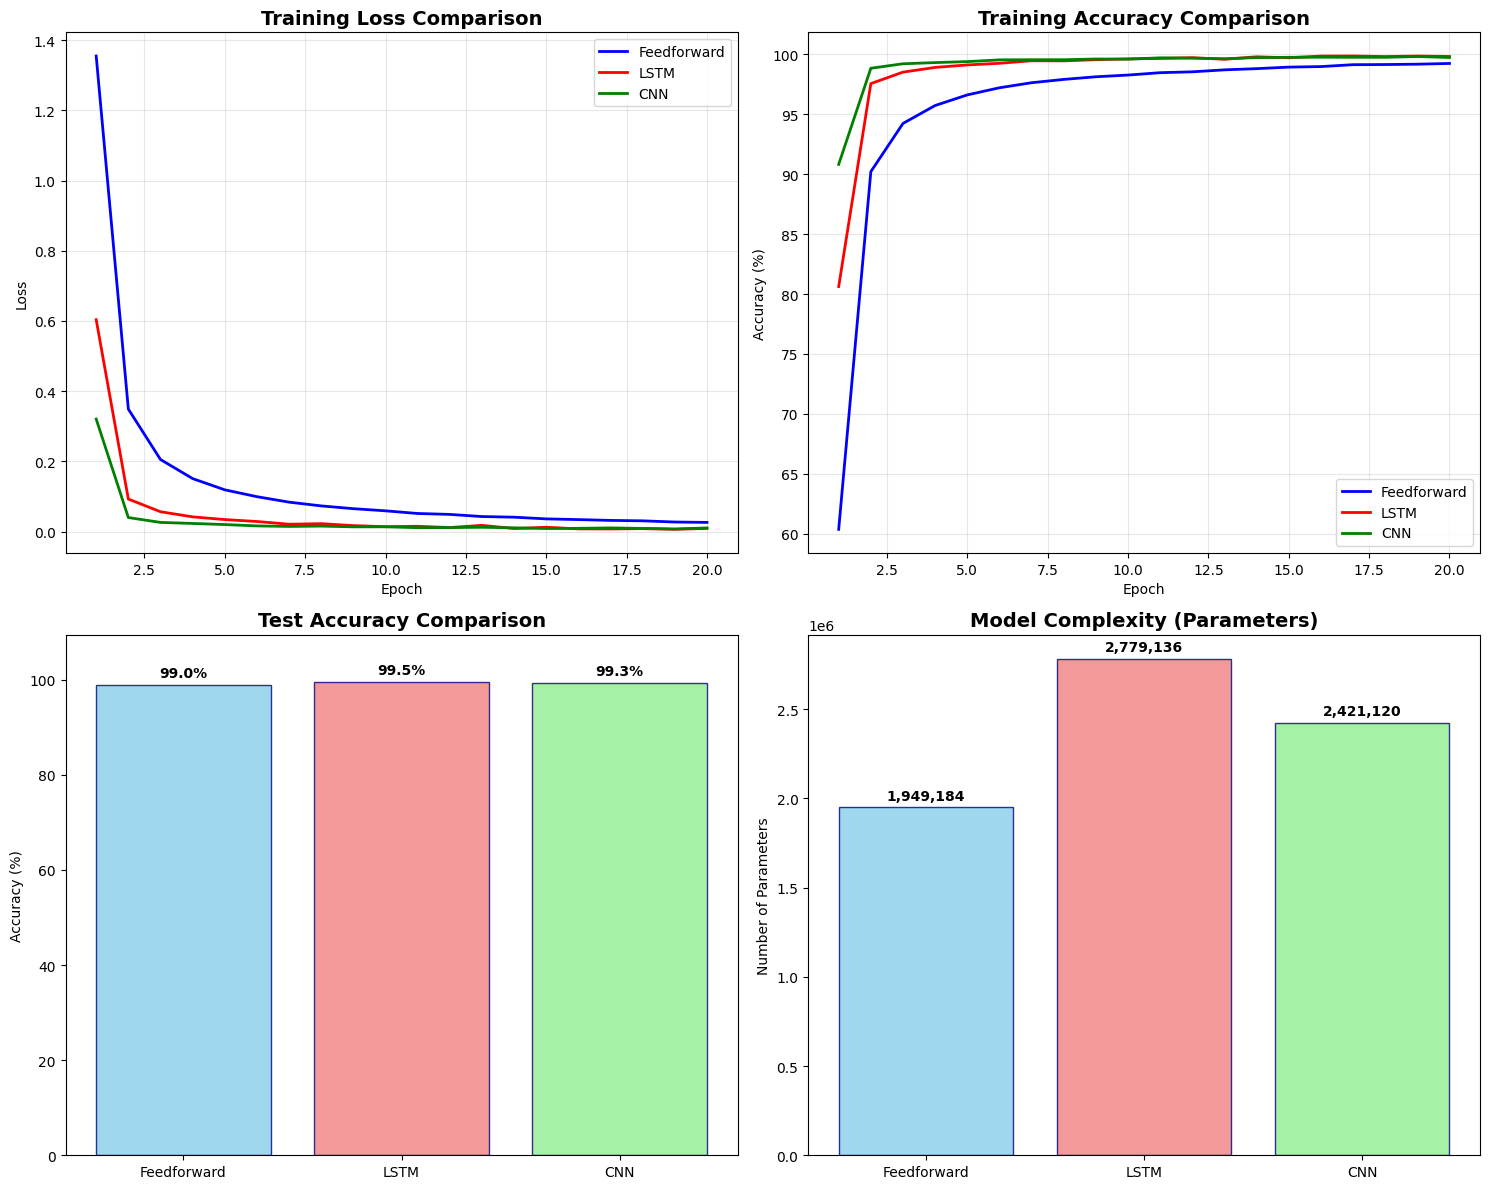

In [46]:
# MODEL COMPARISON AND ANALYSIS
print("="*60)
print("SECTION 6: MODEL COMPARISON AND ANALYSIS")
print("="*60)

# Collect all model results
models_results = {
    'Feedforward NN': {
        'test_accuracy': test_accuracy,
        'train_accuracy': train_accuracies[-1],
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'predictions': predictions,
        'targets': targets
    },
    'LSTM': {
        'test_accuracy': lstm_test_accuracy,
        'train_accuracy': lstm_train_accuracies[-1],
        'train_losses': lstm_train_losses,
        'train_accuracies': lstm_train_accuracies,
        'predictions': lstm_predictions,
        'targets': lstm_targets
    },
    'CNN': {
        'test_accuracy': cnn_test_accuracy,
        'train_accuracy': cnn_train_accuracies[-1],
        'train_losses': cnn_train_losses,
        'train_accuracies': cnn_train_accuracies,
        'predictions': cnn_predictions,
        'targets': cnn_targets
    }
}

# Performance Summary Table
print("MODEL PERFORMANCE COMPARISON")
print("="*50)
print(f"{'Model':<15} {'Test Acc':<10} {'Train Acc':<11} {'Parameters':<12}")
print("-" * 50)

# Calculate parameters for each model
ff_params = sum(p.numel() for p in model.parameters())
lstm_params = sum(p.numel() for p in lstm_model.parameters())
cnn_params = sum(p.numel() for p in cnn_model.parameters())

print(f"{'Feedforward':<15} {test_accuracy:<9.2f}% {train_accuracies[-1]:<10.2f}% {ff_params:<12,}")
print(f"{'LSTM':<15} {lstm_test_accuracy:<9.2f}% {lstm_train_accuracies[-1]:<10.2f}% {lstm_params:<12,}")
print(f"{'CNN':<15} {cnn_test_accuracy:<9.2f}% {cnn_train_accuracies[-1]:<10.2f}% {cnn_params:<12,}")

# Find best model
best_model_name = max(models_results.keys(), key=lambda x: models_results[x]['test_accuracy'])
best_accuracy = models_results[best_model_name]['test_accuracy']

print(f"\n BEST MODEL: {best_model_name} with {best_accuracy:.2f}% test accuracy")

# Detailed comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Training Loss Comparison
axes[0,0].plot(range(1, NUM_EPOCHS+1), train_losses, 'b-', label='Feedforward', linewidth=2)
axes[0,0].plot(range(1, NUM_EPOCHS+1), lstm_train_losses, 'r-', label='LSTM', linewidth=2)
axes[0,0].plot(range(1, NUM_EPOCHS+1), cnn_train_losses, 'g-', label='CNN', linewidth=2)
axes[0,0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Training Accuracy Comparison
axes[0,1].plot(range(1, NUM_EPOCHS+1), train_accuracies, 'b-', label='Feedforward', linewidth=2)
axes[0,1].plot(range(1, NUM_EPOCHS+1), lstm_train_accuracies, 'r-', label='LSTM', linewidth=2)
axes[0,1].plot(range(1, NUM_EPOCHS+1), cnn_train_accuracies, 'g-', label='CNN', linewidth=2)
axes[0,1].set_title('Training Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Accuracy (%)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Test Accuracy Bar Chart
model_names = ['Feedforward', 'LSTM', 'CNN']
test_accuracies = [test_accuracy, lstm_test_accuracy, cnn_test_accuracy]
colors = ['skyblue', 'lightcoral', 'lightgreen']

bars = axes[1,0].bar(model_names, test_accuracies, color=colors, alpha=0.8, edgecolor='navy')
axes[1,0].set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Accuracy (%)')
axes[1,0].set_ylim(0, max(test_accuracies) + 10)

# Add value labels on bars
for bar, acc in zip(bars, test_accuracies):
    axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                  f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

# Model Parameters Comparison
parameters = [ff_params, lstm_params, cnn_params]
bars = axes[1,1].bar(model_names, parameters, color=colors, alpha=0.8, edgecolor='navy')
axes[1,1].set_title('Model Complexity (Parameters)', fontsize=14, fontweight='bold')
axes[1,1].set_ylabel('Number of Parameters')

# Add value labels on bars
for bar, param in zip(bars, parameters):
    axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(parameters)*0.01, 
                  f'{param:,}', ha='center', va='bottom', fontweight='bold', rotation=0)

plt.tight_layout()
plt.show()


In [54]:
# SIMPLE PREDICTION SYSTEM - ALL MODELS
print("="*60)
print("UNIFIED PREDICTION SYSTEM FOR ALL MODELS")
print("="*60)

def predict_complaint(text):
    
    print(f"Analyzing complaint: '{text}'")
    print("="*50)
    
    # Preprocess the input text
    processed_text = improved_preprocessing_pipeline(text)
    sequence = text_to_sequences_pytorch([processed_text], word_to_idx, MAX_LEN)
    sequence = sequence.to(device)
    
    # Get predictions from all three models
    results = []
    
    # Feedforward prediction
    model.eval()
    with torch.no_grad():
        output = model(sequence)
        probabilities = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities).item()
        confidence = probabilities[0][predicted_class].item() * 100
        category = label_encoder.classes_[predicted_class]
        results.append(('Feedforward', category, confidence))
    
    # LSTM prediction
    lstm_model.eval()
    with torch.no_grad():
        output = lstm_model(sequence)
        probabilities = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities).item()
        confidence = probabilities[0][predicted_class].item() * 100
        category = label_encoder.classes_[predicted_class]
        results.append(('LSTM', category, confidence))
    
    # CNN prediction
    cnn_model.eval()
    with torch.no_grad():
        output = cnn_model(sequence)
        probabilities = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities).item()
        confidence = probabilities[0][predicted_class].item() * 100
        category = label_encoder.classes_[predicted_class]
        results.append(('CNN', category, confidence))
    
    # Display results
    print("RESULTS FROM ALL THREE MODELS:")
    print("-" * 40)
    for model_name, category, confidence in results:
        print(f"{model_name:<12}: {category:<25} ({confidence:.1f}%)")
    
    # Find best prediction
    best_model, best_category, best_confidence = max(results, key=lambda x: x[2])
    print(f"\n BEST PREDICTION: {best_category} by {best_model} ({best_confidence:.1f}%)")
    
    # Check if all models agree
    categories = [result[1] for result in results]
    if len(set(categories)) == 1:
        print(f" ALL MODELS predicted same category")
    else:
        print(f"  Models have different predictions")
    
    return best_category, best_confidence

# Test the unified function
print("Testing the unified prediction function:")
print("\n" + "="*60)

# Quick test examples
test_examples = [
    "The vegetables were rotten and smelled bad",
    "dealing last through but order not confirmed.",
    "The refund was partially processed, not the full amount."
]

for i, example in enumerate(test_examples, 1):
    print(f"\nTEST {i}:")
    predict_complaint(example)
    print("\n" + "-"*60)


print("Just use: predict_complaint('your complaint text here')")
print("This one function shows all three models at once!")

UNIFIED PREDICTION SYSTEM FOR ALL MODELS
Testing the unified prediction function:


TEST 1:
Analyzing complaint: 'The vegetables were rotten and smelled bad'
RESULTS FROM ALL THREE MODELS:
----------------------------------------
Feedforward : Poor Quality Vegetables   (100.0%)
LSTM        : Poor Quality Vegetables   (100.0%)
CNN         : Poor Quality Vegetables   (100.0%)

 BEST PREDICTION: Poor Quality Vegetables by Feedforward (100.0%)
 ALL MODELS predicted same category

------------------------------------------------------------

TEST 2:
Analyzing complaint: 'dealing last through but order not confirmed.'
RESULTS FROM ALL THREE MODELS:
----------------------------------------
Feedforward : Payment Issue             (100.0%)
LSTM        : Payment Issue             (100.0%)
CNN         : Payment Issue             (100.0%)

 BEST PREDICTION: Payment Issue by LSTM (100.0%)
 ALL MODELS predicted same category

------------------------------------------------------------

TEST 3:
Anal

In [48]:
# ...existing code...
# Evaluate LSTM model
lstm_test_accuracy, lstm_predictions, lstm_targets = evaluate_model(lstm_model, test_loader)

print(f"\nLSTM Model Performance:")
print(f"  Test Accuracy: {lstm_test_accuracy:.2f}%")
print(f"  Training Accuracy (final): {lstm_train_accuracies[-1]:.2f}%")

# LSTM classification report
print("\nDetailed Classification Report (LSTM):")
print("-" * 50)
lstm_report = classification_report(
    lstm_targets,
    lstm_predictions,
    target_names=label_encoder.classes_,
    digits=3
)
print(lstm_report)

print("LSTM model training completed!")
# ...existing code...


LSTM Model Performance:
  Test Accuracy: 99.49%
  Training Accuracy (final): 99.81%

Detailed Classification Report (LSTM):
--------------------------------------------------
                                   precision    recall  f1-score   support

              App/Technical Issue      0.996     0.992     0.994       505
           Customer Support Delay      1.000     1.000     1.000       518
                  Damaged Product      0.988     0.992     0.990       503
         Delivery Executive Issue      0.977     0.991     0.984       212
                 Duplicate Charge      1.000     0.996     0.998       514
        Inconsistent Order Status      0.996     0.992     0.994       514
                  Incorrect Order      0.984     0.992     0.988       504
                    Late Delivery      0.998     0.996     0.997       525
                    Missing Items      0.979     0.989     0.984       526
            Non-Responsive Seller      1.000     0.996     0.998       51

In [49]:
# ...existing code...
# Evaluate CNN model
cnn_test_accuracy, cnn_predictions, cnn_targets = evaluate_model(cnn_model, test_loader)

print(f"\nCNN Model Performance:")
print(f"  Test Accuracy: {cnn_test_accuracy:.2f}%")
print(f"  Training Accuracy (final): {cnn_train_accuracies[-1]:.2f}%")

# CNN classification report
print("\nDetailed Classification Report (CNN):")
print("-" * 50)
cnn_report = classification_report(
    cnn_targets,
    cnn_predictions,
    target_names=label_encoder.classes_,
    digits=3
)
print(cnn_report)

print("CNN model training completed!")
# ...existing code...


CNN Model Performance:
  Test Accuracy: 99.33%
  Training Accuracy (final): 99.73%

Detailed Classification Report (CNN):
--------------------------------------------------
                                   precision    recall  f1-score   support

              App/Technical Issue      0.973     0.998     0.985       505
           Customer Support Delay      1.000     0.996     0.998       518
                  Damaged Product      0.980     0.992     0.986       503
         Delivery Executive Issue      0.981     0.995     0.988       212
                 Duplicate Charge      0.996     0.996     0.996       514
        Inconsistent Order Status      0.988     0.992     0.990       514
                  Incorrect Order      0.969     0.992     0.980       504
                    Late Delivery      1.000     0.992     0.996       525
                    Missing Items      0.990     0.987     0.989       526
            Non-Responsive Seller      1.000     0.998     0.999       515


In [50]:
# ...existing code...
# Evaluate Feedforward (FF) model
ff_test_accuracy, ff_predictions, ff_targets = evaluate_model(model, test_loader)

print(f"\nFeedforward Model Performance:")
print(f"  Test Accuracy: {ff_test_accuracy:.2f}%")
print(f"  Training Accuracy (final): {train_accuracies[-1]:.2f}%")

# Feedforward classification report
print("\nDetailed Classification Report (Feedforward):")
print("-" * 50)
ff_report = classification_report(
    ff_targets,
    ff_predictions,
    target_names=label_encoder.classes_,
    digits=3
)
print(ff_report)

print("Feedforward model evaluation completed!")
# ...existing code...


Feedforward Model Performance:
  Test Accuracy: 98.98%
  Training Accuracy (final): 99.23%

Detailed Classification Report (Feedforward):
--------------------------------------------------
                                   precision    recall  f1-score   support

              App/Technical Issue      0.988     0.978     0.983       505
           Customer Support Delay      0.998     0.990     0.994       518
                  Damaged Product      0.978     0.984     0.981       503
         Delivery Executive Issue      0.972     0.972     0.972       212
                 Duplicate Charge      0.994     0.990     0.992       514
        Inconsistent Order Status      0.979     0.996     0.987       514
                  Incorrect Order      0.971     0.982     0.976       504
                    Late Delivery      1.000     0.996     0.998       525
                    Missing Items      0.979     0.987     0.983       526
            Non-Responsive Seller      1.000     0.990     

## Overfitting Mitigation & Leakage Diagnostics
We now load the expanded 20K dataset, rebuild the vocabulary, create a Train/Val/Test split, add stronger regularization with early stopping, and run a label-shuffle sanity check.

Steps:
1. Load `Expanded_Complaints_20K.csv`.
2. Rebuild vocab (frequency threshold + UNK/PAD).
3. Stratified split (70/15/15).
4. Train with early stopping, dropout, weight decay, gradient clipping.
5. Plot train vs val curves.
6. Label-shuffle sanity (should drop to chance accuracy).
7. Compute macro F1 on val/test.
8. Re-check exclusive token ratio.
